In [1]:
import mcstasscript as ms

configurator = ms.Configurator()
configurator.set_mcrun_path("/Applications/McStas-3.2.app/Contents/Resources/mcstas/3.2/bin")
configurator.set_mcstas_path("/Applications/McStas-3.2.app/Contents/Resources/mcstas/3.2")

In [2]:
KVASIR = ms.McStas_instr("KVASIRscript")

Ef = KVASIR.add_parameter("Ef", comment="Ef [meV]")

d_AD = KVASIR.add_parameter("d_AD", comment="Distance from analyser to detector[m]")

d_SA = KVASIR.add_parameter("d_SA", comment="Distance from sample to analyser[m]")

In [3]:
# PARAMETERS
D_lambda= KVASIR.add_declare_var("double", "D_lambda", value=0.1)
width= KVASIR.add_declare_var("double", "width", value=0.001)
u = KVASIR.add_declare_var("double", "u", value=1E-4)
d_PG= KVASIR.add_declare_var("double", "d_PG", value=3.355) 

lamda_f = KVASIR.add_declare_var("double", "lambda_f") #final wavelenght
KVASIR.append_initialize("lambda_f=1/(0.11056*sqrt(Ef));")

#ANALYZER CALCULATION

tA = KVASIR.add_declare_var("double", "tA") #Bragg angle of analyzer
KVASIR.append_initialize("tA=asin(lambda_f/(2*d_PG))*RAD2DEG;")

tS= KVASIR.add_declare_var("double", "tS") #Bragg angle of sample
KVASIR.append_initialize("tS=20;")

x_tS_d = KVASIR.add_declare_var("double", "x_tS_d") #x-component of analyzer position relative sample
KVASIR.append_initialize("x_tS_d = 2/3*d_SA*sin(tS*DEG2RAD); ")
x_tS = KVASIR.add_declare_var("double", "x_tS") #x-componenet of sample Bragg angle 
KVASIR.append_initialize("x_tS = x_tS_d/d_SA;")

y_tS_d = KVASIR.add_declare_var("double", "y_tS_d") #y-component of analyzer position relative sample
KVASIR.append_initialize("y_tS_d = sqrt(d_SA*d_SA*sin(tS*DEG2RAD)*sin(tS*DEG2RAD) - x_tS_d*x_tS_d);")
y_tS = KVASIR.add_declare_var("double", "y_tS") #y-componenet of sample Bragg angle 
KVASIR.append_initialize("y_tS = y_tS_d/d_SA;")

z_tS_d = KVASIR.add_declare_var("double", "z_tS_d") #x-component of analyzer position relative sample
KVASIR.append_initialize("z_tS_d = d_SA*cos(tS*DEG2RAD) ;")
z_tS = KVASIR.add_declare_var("double", "z_tS") #x-componenet of sample Bragg angle 
KVASIR.append_initialize("z_tS = z_tS_d/d_SA;")

#DETECTOR CALCULATION

d_SDz = KVASIR.add_declare_var("double", "d_SDz") #z-component of distance between sample and detector
KVASIR.append_initialize("d_SDz=d_SA+d_AD*cos(2*tA*DEG2RAD);")

h_D = KVASIR.add_declare_var("double", "h_D") #heigt of detector relative arm Bragg 
KVASIR.append_initialize("h_D=d_AD*sin(2*tA*DEG2RAD);")

tRDx = KVASIR.add_declare_var("double", "tRDx") #rotation of detectors around x-axis
KVASIR.append_initialize("tRDx=-RAD2DEG*atan(d_AD/d_SDz*sin(2*tA*DEG2RAD));")

tRDy = KVASIR.add_declare_var("double", "tRDy") #rotation of detectors around y-axis
KVASIR.append_initialize("tRDy=360*0.0125/(2*d_SDz*3.142);")

d_SD = KVASIR.add_declare_var("double", "d_SD") #distance between sample and detector
KVASIR.append_initialize("d_SD=d_AD*sin(2*tA*DEG2RAD)/sin(tRDx*DEG2RAD);")

In [4]:
origin = KVASIR.add_component("origin", "Progress_bar", AT=[0,0,0], RELATIVE="ABSOLUTE")
arm_origin = KVASIR.add_component("arm_origin", "Arm", AT = [0,0,0], RELATIVE="PREVIOUS", ROTATED=[0,0, 0], ROTATED_RELATIVE="PREVIOUS")

In [5]:
arm_bragg = KVASIR.add_component("arm_bragg", "Arm", AT = [0,0,0], RELATIVE="PREVIOUS", ROTATED=["x_tS-tS", y_tS, 0], ROTATED_RELATIVE="arm_origin")

In [6]:
source = KVASIR.add_component("source", "Source_Maxwell_3", AT=[0,0,0], RELATIVE="PREVIOUS", ROTATED=[0,0,0], ROTATED_RELATIVE="arm_origin")

source.xwidth=width
source.yheight=width
source.Lmin= "lambda_f-D_lambda/2"
source.Lmax= "lambda_f+D_lambda/2"
source.dist= d_SA
source.focus_yh=width
source.focus_xw=width
source.T1=300
source.T2=300
source.T3=300
source.I1=1E15
source.I2=1E15
source.I3=1E15

print(source)

COMPONENT source = Source_Maxwell_3(
  yheight = width, // [m]
  xwidth = width, // [m]
  Lmin = lambda_f-D_lambda/2, // [AA]
  Lmax = lambda_f+D_lambda/2, // [AA]
  dist = d_SA, // [m]
  focus_xw = width, // [m]
  focus_yh = width, // [m]
  T1 = 300, // [K]
  T2 = 300, // [K]
  T3 = 300, // [K]
  I1 = 1000000000000000.0, // [1/(cm**2*st)]
  I2 = 1000000000000000.0, // [1/(cm**2*st)]
  I3 = 1000000000000000.0 // [1/(cm**2*st)]
)
AT (0, 0, 0) RELATIVE PREVIOUS
ROTATED (0, 0, 0) RELATIVE PREVIOUS


In [7]:
PSD_monitor_analyser = KVASIR.add_component("PSD_monitor_analyser", "PSD_monitor", AT=[0,0,"d_SA-u"], RELATIVE="PREVIOUS")

PSD_monitor_analyser.nx=40
PSD_monitor_analyser.ny = 40
PSD_monitor_analyser.xwidth = "width*2"
PSD_monitor_analyser.yheight = "width*2"
PSD_monitor_analyser.restore_neutron=1
PSD_monitor_analyser.filename='"PSD_analyzer.dat"'

In [8]:
Analyser = KVASIR.add_component("Analyzer","Monochromator_flat", AT = [0,0,"u"], RELATIVE="PREVIOUS", ROTATED=["90-tA",90,0], ROTATED_RELATIVE="PREVIOUS" )

Analyser.zwidth = "width*2"
Analyser.yheight = "width*2"
Analyser.mosaich = 37
Analyser.mosaicv = 37
Analyser.Q = 1.87278
Analyser.DM = d_PG
Analyser.r0 = 0.8

KVASIR.component_help("Monochromator_flat")

 ___ Help Monochromator_flat ________________________________________________________
|optional parameter|required parameter|default value|user specified value|
zmin = -0.05 [m] // Lower horizontal (z) bound of crystal
zmax = 0.05 [m] // Upper horizontal (z) bound of crystal
ymin = -0.05 [m] // Lower vertical (y) bound of crystal
ymax = 0.05 [m] // Upper vertical (y) bound of crystal
zwidth = 0.0 [m] // Width of crystal, instead of zmin and zmax
yheight = 0.0 [m] // Height of crystal, instead of ymin and ymax
mosaich = 30.0 [arc minutes] // Horizontal mosaic (in z direction) (FWHM)
mosaicv = 30.0 [arc minutes] // Vertical mosaic (in y direction) (FWHM)
r0 = 0.7 [1] // Maximum reflectivity
Q = 1.8734 [1/angstrom] // Magnitude of scattering vector
DM = 0.0 [AA] // monochromator d-spacing, instead of Q = 2*pi/DM
-------------------------------------------------------------------------------------


In [9]:
N_detectors  = 15

for n in range(N_detectors):
    if n%2 == 0: #even number
        KVASIR.add_component(f"arm_detector_{int(n/2)}", "Arm", AT = [0,0,0], RELATIVE="source", ROTATED=[0,f"tRDy*{n/2}",0], ROTATED_RELATIVE="source")
        Detector = KVASIR.add_component(f"Detector_{int(n/2)}", "PSD_monitor", AT = [0,h_D, d_SDz], RELATIVE="PREVIOUS", ROTATED=[0,f"tRDy*{n/2}",0], ROTATED_RELATIVE="arm_origin")
        Detector.nx = 40
        Detector.ny = 40
        Detector.xwidth = 0.0125
        Detector.yheight = 0.01
        Detector.restore_neutron=1
        Detector.filename=f'"Detector_{int(n/2)}.dat"'

        E_monitor = KVASIR.add_component(f"E_monitor_{int(n/2)}", "E_monitor", AT= [0,0,"u"], RELATIVE="PREVIOUS")
        E_monitor.xwidth = 0.0125
        E_monitor.yheight = 0.01
        E_monitor.Emin = 1.5
        E_monitor.Emax = 2.5
        E_monitor.restore_neutron = 1
        E_monitor.nE = 1000
        E_monitor.filename=f'"E_monitor_{int(n/2)}.dat"'
    if n%2 == 1: #odd number
        KVASIR.add_component(f"arm_detector_m{int((n+1)/2)}", "Arm", AT = [0,0,0], RELATIVE="source", ROTATED=[0,f"-tRDy*{(n+1)/2}",0], ROTATED_RELATIVE="source")
        Detector = KVASIR.add_component(f"Detector_m{int((n+1)/2)}", "PSD_monitor", AT = [0,h_D, d_SDz], RELATIVE="PREVIOUS", ROTATED=[0,f"-tRDy*{(n+1)/2}",0], ROTATED_RELATIVE="arm_origin")
        Detector.nx = 40
        Detector.ny = 40
        Detector.xwidth = 0.0125
        Detector.yheight = 0.01
        Detector.restore_neutron=1
        Detector.filename=f'"Detector_m{int((n+1)/2)}.dat"'

        E_monitor = KVASIR.add_component(f"E_monitor_m{int((n+1)/2)}", "E_monitor", AT= [0,0,"u"], RELATIVE="PREVIOUS")
        E_monitor.xwidth = 0.0125
        E_monitor.yheight = 0.01
        E_monitor.Emin = 1.5
        E_monitor.Emax = 2.5
        E_monitor.restore_neutron = 1
        E_monitor.nE = 1000
        E_monitor.filename=f'"E_monitor_m{int((n+1)/2)}.dat"' 




In [10]:
KVASIR.set_parameters(Ef=1.83, d_SA=3, d_AD=2)
KVASIR.show_parameters()

 Ef    = 1.83  // Ef [meV]
 d_AD  = 2     // Distance from analyser to detector[m]
 d_SA  = 3     // Distance from sample to analyser[m]


In [11]:
KVASIR.show_components()

origin               Progress_bar       AT      (0, 0, 0)          ABSOLUTE         
arm_origin           Arm                AT      (0, 0, 0)          RELATIVE PREVIOUS 
                                        ROTATED (0, 0, 0)          RELATIVE PREVIOUS
arm_bragg            Arm                AT      (0, 0, 0)          RELATIVE PREVIOUS 
                                        ROTATED (x_tS-tS, y_tS, 0) RELATIVE PREVIOUS
source               Source_Maxwell_3   AT      (0, 0, 0)          RELATIVE PREVIOUS 
                                        ROTATED (0, 0, 0)          RELATIVE PREVIOUS
PSD_monitor_analyser PSD_monitor        AT      (0, 0, d_SA-u)     RELATIVE PREVIOUS
Analyzer             Monochromator_flat AT      (0, 0, u)          RELATIVE PREVIOUS 
                                        ROTATED (90-tA, 90, 0)     RELATIVE PREVIOUS
arm_detector_0       Arm                AT      (0, 0, 0)          RELATIVE source   
                                        ROTATED (0, tRDy*0.0

In [12]:
KVASIR.set_parameters(Ef=1.82,d_SA=3,d_AD=2)
data = KVASIR.backengine()


loading system configuration
loading user configuration from /Users/amaliedavidsen/.mcstas/3.2/mccode_config.json
INFO: Using directory: "/Users/amaliedavidsen/Documents/KVASIR/MCStasScript/KVASIRscript_16"
INFO: Regenerating c-file: KVASIRscript.c
CFLAGS=

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
INFO: Recompiling: ./KVASIRscript.out
./KVASIRscript.c:9152:48: warning: format string is not a string literal (potentially insecure) [-Wformat-security]
  if (!strcmp(filename,"\0")) sprintf(filename,NAME_CURRENT_COMP);
                                               ^~~~~~~~~~~~~~~~~
./KVASIRscript.c:622:27: note: expanded from macro 'NAME_CURRENT_COMP'
#define NAME_CURRENT_COMP (_comp->_name)
                          ^~~~~~~~~~~~~
/Library/Developer/Comm

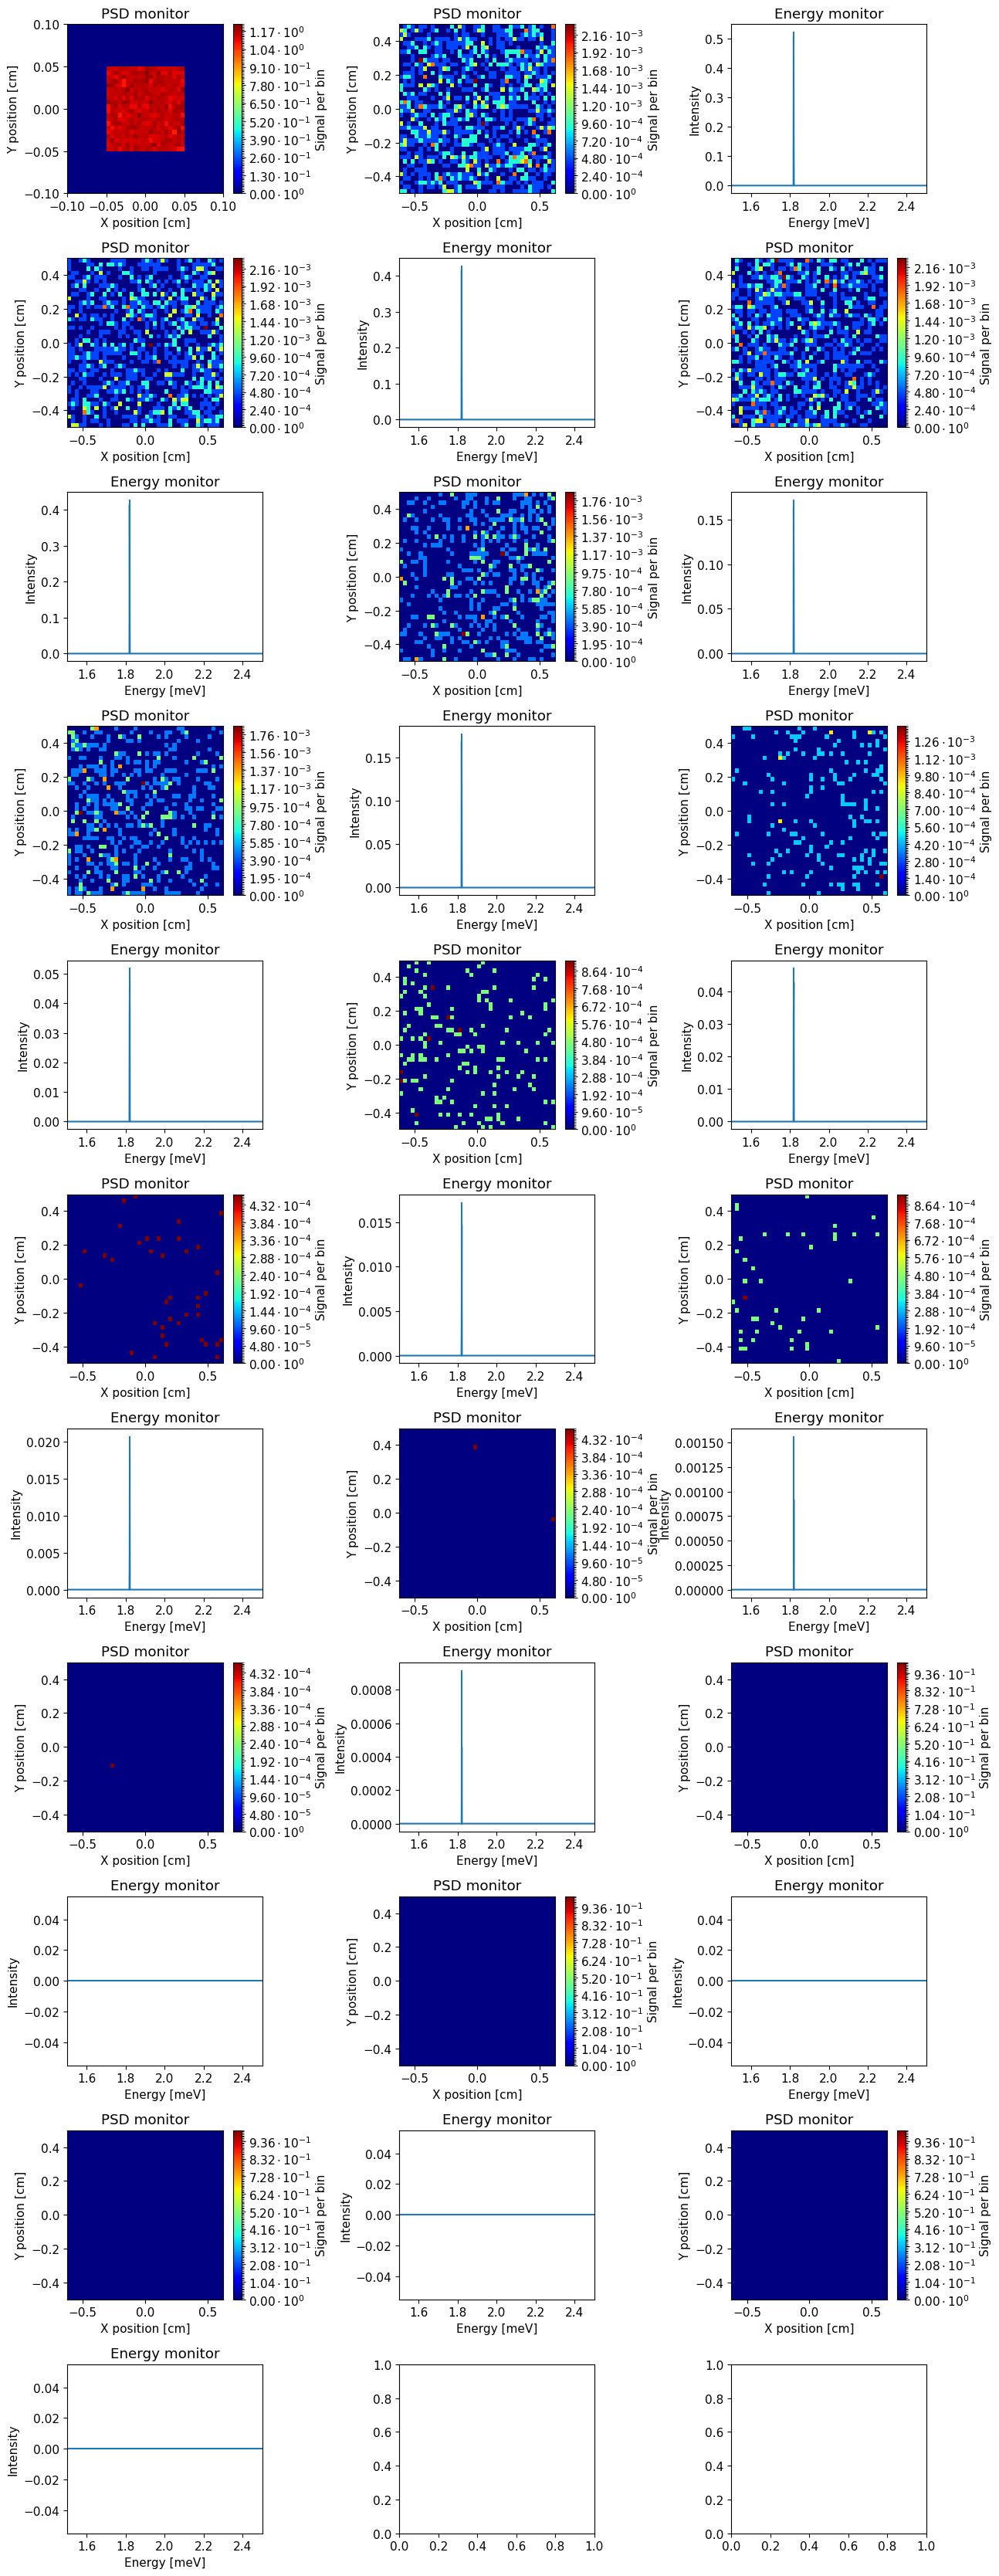

In [13]:
ms.make_sub_plot(data)